In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from sklearn.model_selection import train_test_split

# Load the training data
full_data = np.loadtxt('../hw2/wine/wine.data.txt', delimiter=',')

np.random.shuffle(full_data)

train_data_full = full_data[:130, :]
train_labels = train_data_full[:, 0]
train_features = train_data_full[:, 1:]

test_data_full = full_data[130:, :]
test_labels = test_data_full[:, 0]
test_features = test_data_full[:, 1:]

FLAVANOIDS_IDX = 7
COLOR_INTENSITY_IDX = 9


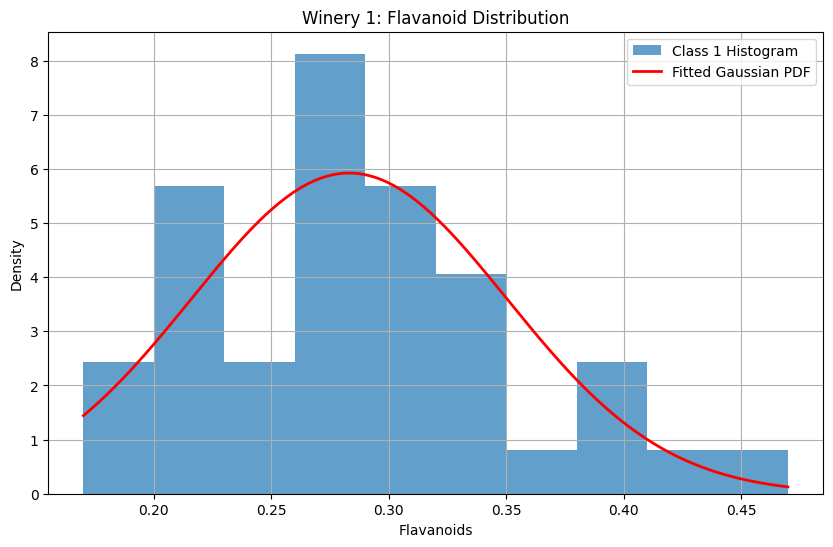

In [7]:
# Isolate the flavanoids feature for all training data
train_flavanoids = train_features[:, FLAVANOIDS_IDX]

# Get the flavanoid data specifically for class 1
class_1_flavanoids = train_flavanoids[train_labels == 1]

# Fit the Gaussian: calculate mean and variance
mu_1 = np.mean(class_1_flavanoids)
var_1 = np.var(class_1_flavanoids)

# --- Plotting ---
plt.figure(figsize=(10, 6))
# 1. Plot the histogram of the data [cite: 83]
plt.hist(class_1_flavanoids, bins=10, density=True, alpha=0.7, label='Class 1 Histogram')

# 2. Plot the density function of the fitted Gaussian [cite: 84]
x_axis = np.linspace(min(class_1_flavanoids), max(class_1_flavanoids), 200)
pdf = norm.pdf(x_axis, loc=mu_1, scale=np.sqrt(var_1))
plt.plot(x_axis, pdf, 'r-', lw=2, label='Fitted Gaussian PDF')

plt.title('Winery 1: Flavanoid Distribution')
plt.xlabel('Flavanoids')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

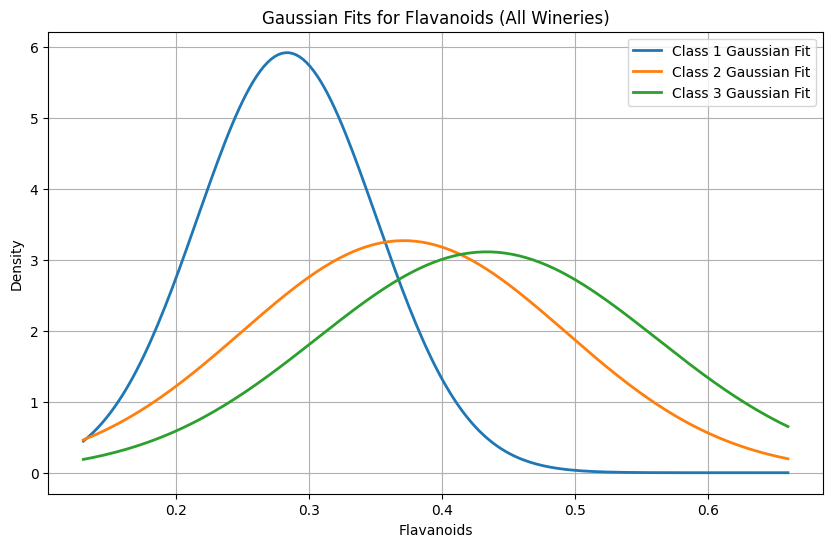

The test error rate for the 1D (Flavanoids) classifier is: 0.3750


In [3]:
# Dictionaries to store model parameters
priors = {}
gauss_1d_params = {}

plt.figure(figsize=(10, 6))
x_axis = np.linspace(np.min(train_flavanoids), np.max(train_flavanoids), 200)

# --- Fit a Gaussian and calculate prior for each class ---
for k in range(1, 4):
    class_data = train_flavanoids[train_labels == k]
    priors[k] = len(class_data) / len(train_labels)
    mu, var = np.mean(class_data), np.var(class_data)
    gauss_1d_params[k] = {'mean': mu, 'var': var}
    
    # Plot the Gaussian PDF for the current class
    pdf = norm.pdf(x_axis, loc=mu, scale=np.sqrt(var))
    plt.plot(x_axis, pdf, lw=2, label=f'Class {k} Gaussian Fit')

plt.title('Gaussian Fits for Flavanoids (All Wineries)')
plt.xlabel('Flavanoids')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


# --- Classify Test Data and Calculate Error ---
test_flavanoids = test_features[:, FLAVANOIDS_IDX]
predictions_1d = []
for x_test in test_flavanoids:
    posteriors = []
    for k in range(1, 4):
        # Calculate likelihood from the stored Gaussian parameters
        likelihood = norm.pdf(x_test, loc=gauss_1d_params[k]['mean'], scale=np.sqrt(gauss_1d_params[k]['var']))
        # Posterior is proportional to prior * likelihood
        posterior = priors[k] * likelihood
        posteriors.append(posterior)
    
    # Predicted class is the one with the highest posterior
    predicted_class = np.argmax(posteriors) + 1
    predictions_1d.append(predicted_class)

# Calculate the test error rate [cite: 86]
errors_1d = np.sum(np.array(predictions_1d) != test_labels)
error_rate_1d = errors_1d / len(test_labels)
print(f"The test error rate for the 1D (Flavanoids) classifier is: {error_rate_1d:.4f}")

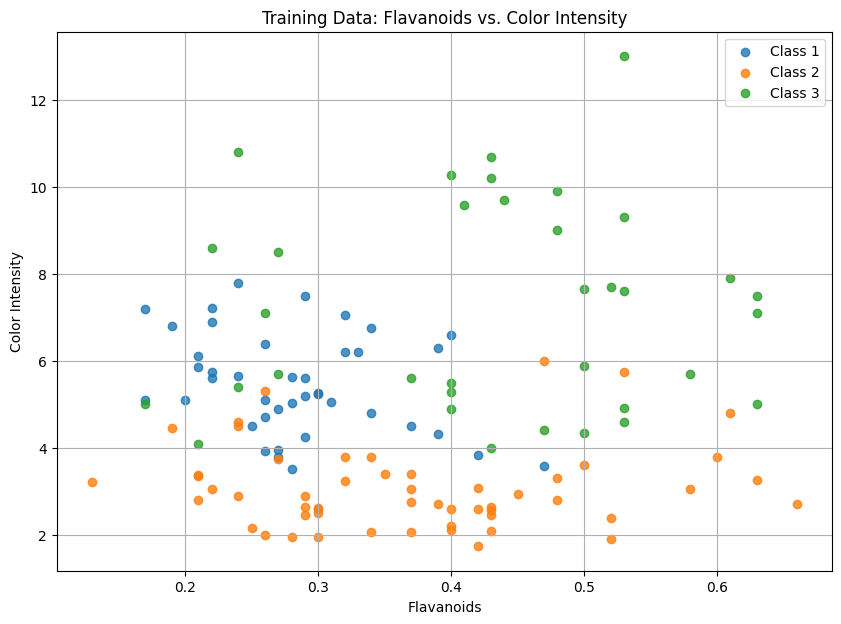

In [4]:
# Isolate the two features for the training set
train_2d = train_features[:, [FLAVANOIDS_IDX, COLOR_INTENSITY_IDX]]

# --- Create the scatter plot ---
plt.figure(figsize=(10, 7))
# Plot each class with a different color/marker
for k in range(1, 4):
    class_data = train_2d[train_labels == k]
    plt.scatter(class_data[:, 0], class_data[:, 1], label=f'Class {k}', alpha=0.8)

plt.title('Training Data: Flavanoids vs. Color Intensity')
plt.xlabel('Flavanoids')
plt.ylabel('Color Intensity')
plt.legend()
plt.grid(True)

# Save a reference to this figure so we can add to it in Part (d)
plot_figure = plt.gcf()
plt.show()

The test error rate for the 2D classifier is: 0.1667


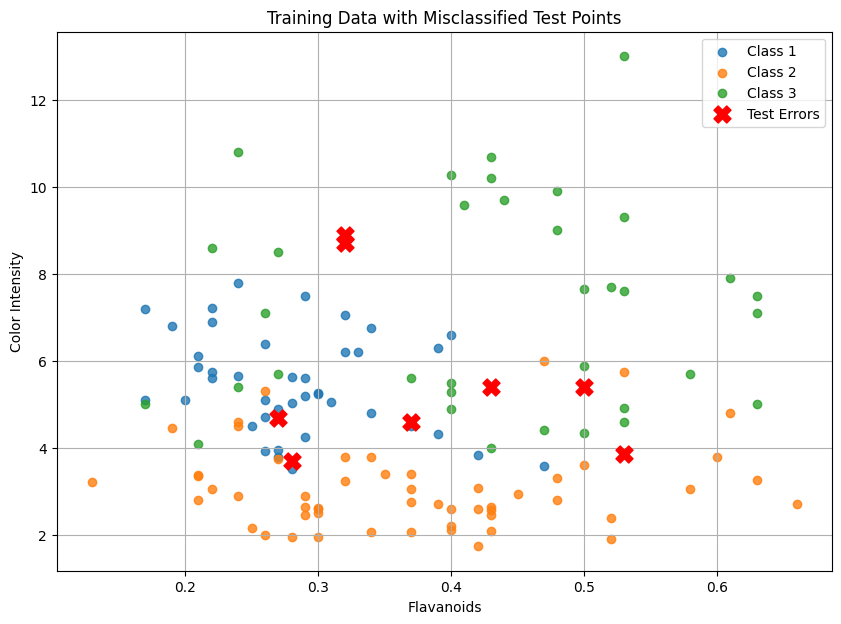

In [6]:
# --- Fit 2D Gaussians for each class ---
gauss_2d_params = {}
for k in range(1, 4):
    class_data = train_2d[train_labels == k]
    gauss_2d_params[k] = {
        'mean': np.mean(class_data, axis=0),
        'cov': np.cov(class_data, rowvar=False)
    }

# --- Classify Test Data and Find Errors ---
test_2d = test_features[:, [FLAVANOIDS_IDX, COLOR_INTENSITY_IDX]]
predictions_2d = []
error_indices = []
regularization_value = 1e-6 # Small value to ensure matrix is invertible

for i, x_test in enumerate(test_2d):
    posteriors = []
    for k in range(1, 4):
        params = gauss_2d_params[k]
        mean_vec = params['mean']
        cov_mat = params['cov']
        
        # Regularize the covariance matrix to prevent numerical errors
        cov_mat_reg = cov_mat + np.eye(cov_mat.shape[0]) * regularization_value
        
        likelihood = multivariate_normal.pdf(x_test, mean=mean_vec, cov=cov_mat_reg)
        posteriors.append(priors[k] * likelihood)
    
    predicted_class = np.argmax(posteriors) + 1
    predictions_2d.append(predicted_class)
    
    # If prediction is wrong, save the index
    if predicted_class != test_labels[i]:
        error_indices.append(i)

# Calculate the test error rate for the 2D model [cite: 89]
error_rate_2d = len(error_indices) / len(test_labels)
print(f"The test error rate for the 2D classifier is: {error_rate_2d:.4f}")

# --- Plot the misclassified points on the scatter plot from Part (c) ---
error_points = test_2d[error_indices]

# Use the figure we saved earlier
plt.figure(plot_figure)
plt.scatter(error_points[:, 0], error_points[:, 1], 
            marker='X', color='red', s=150, label='Test Errors', zorder=5)
plt.title('Training Data with Misclassified Test Points')
plt.legend()
plt.show()